In [31]:
%load_ext autoreload
%autoreload 2
import torch
import scipy.ndimage
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from omegaconf import OmegaConf
import pytorch_lightning as pl
import torchvision.models as models


from brainage.model.agemodel_2dslices import AgeModel2DSlices
from brainage.dataset.dataset2d import SliceDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
#ckpt = '/is/ei/thepp/projects/brainage/outputs/brainage/2d_slices/2020-07-17/13-41-27/brainage/wkzu7mla/checkpoints/epoch=20.ckpt'
#ckpt = '/is/ei/thepp/projects/brainage/outputs/brainage/2d_slices/2020-07-17/16-25-49/brainage/2nozggcx/checkpoints/epoch=4.ckpt'
ckpt = '/is/ei/thepp/projects/brainage/outputs/brainage/2d_slices/2020-07-17/19-29-30/brainage/17jixlaf/checkpoints/epoch=17.ckpt'
out_dir = Path('../../outputs/plots_l2_abs')
out_dir.mkdir(exist_ok=True)

In [33]:
model = AgeModel2DSlices.load_from_checkpoint(ckpt, train_ds=None, val_ds=None)
model.eval()

AgeModel2DSlices(
  (loss_criterion): l2_loss()
  (features_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentu

In [51]:
cfg = OmegaConf.load('../../config/config.yaml')
with Path(cfg.dataset.val).open('r') as f:
    val_keys = [l.strip() for l in f.readlines()]

info_df = pd.read_feather(cfg.dataset.info)
if cfg.dataset.slicing == 'range':
        slice_selection = np.arange(start=cfg.dataset.slices[0], 
                                    stop=cfg.dataset.slices[1],
                                    step=cfg.dataset.slices[2])
        info_df = info_df[info_df['slice'].isin(slice_selection)]
elif cfg.dataset.slicing == 'list':
    slice_selection = cfg.dataset.slices
    info_df = info_df[info_df['slice'].isin(slice_selection)]
    
#info_df = info_df[(info_df['slice']>39) & (info_df['slice']<81)] # 56
info_val = info_df[info_df.key.isin(val_keys)]
ds_val = SliceDataset(cfg.dataset.data, 
                      info=info_val, preload=cfg.dataset.preload, zoom=cfg.dataset.zoom)

In [61]:
idx = 800
N = 200
pos = np.zeros(N)
ca = np.zeros(N)
pa = np.zeros((2, N))
for idx in range(N):
    # prediction
    sample = ds_val[idx]
    input = torch.tensor(sample['data'][np.newaxis, ...]).float()
    sl = torch.tensor(sample['slice']).float()
    y = model(input, sl)
    model_prediction = y.detach().numpy()
    mu = model_prediction[0, 0]
    sigma = np.exp(model_prediction[0, 1])
    ca[idx] = sample['label'][0]
    pos[idx] = sl
    pa[0, idx] = mu
    pa[1, idx] = sigma
    #print(f'predicted age (model) chron. age {ca[idx]:.1f} slice {sl}:  {pa[0, idx]:.2f} +/- {pa[1, idx]:.2f}')

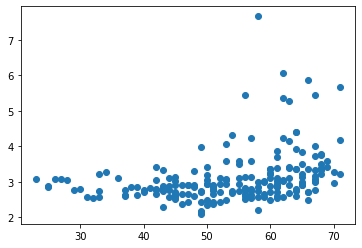

In [62]:
plt.scatter(ca, pa[1])

In [7]:
class GradCam(torch.nn.Module):
    def __init__(self):
        super(GradCam, self).__init__()
        model = AgeModel2DSlices.load_from_checkpoint(ckpt, train_ds=None, val_ds=None)
        self.features_conv = torch.nn.Sequential(*list(model.net.children())[:-2])
        self.avgpool = model.net.avgpool
        self.fc = model.net.fc
        self.gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        y = self.features_conv(x)

        # register the hook
        h = y.register_hook(self.activations_hook)

        y = self.avgpool(y)
        y = torch.flatten(y, 1)
        y = self.fc(y)
        #y = F.softmax(y, dim=1)
        return y

    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [8]:
cam = GradCam()
a = cam.eval()

predicted age (model) tensor([53.3009], grad_fn=<SelectBackward>) chron. age 52.0
predicted age (grad cam) tensor([53.3009], grad_fn=<SelectBackward>)
(10, 12) (300, 375)


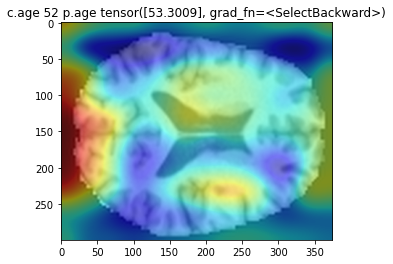

0.5152415 1.002012
predicted age (model) tensor([50.6273], grad_fn=<SelectBackward>) chron. age 52.0
predicted age (grad cam) tensor([50.6273], grad_fn=<SelectBackward>)
(10, 12) (300, 375)


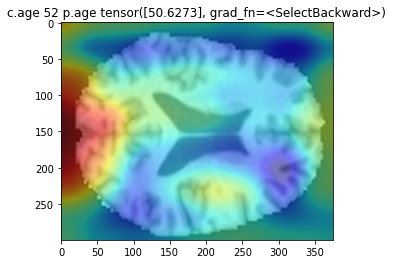

0.39390033 1.007471
predicted age (model) tensor([52.7308], grad_fn=<SelectBackward>) chron. age 52.0
predicted age (grad cam) tensor([52.7308], grad_fn=<SelectBackward>)
(10, 12) (300, 375)


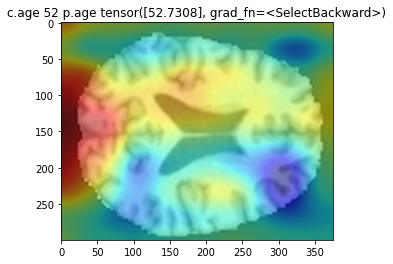

0.36083683 1.0016254
predicted age (model) tensor([53.9602], grad_fn=<SelectBackward>) chron. age 52.0
predicted age (grad cam) tensor([53.9602], grad_fn=<SelectBackward>)
(10, 12) (300, 375)


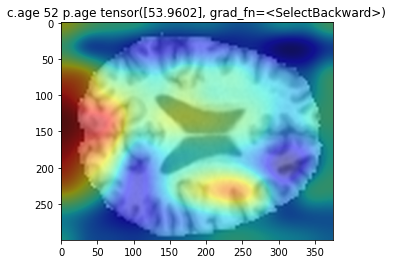

0.46707383 1.0013149
predicted age (model) tensor([57.9034], grad_fn=<SelectBackward>) chron. age 52.0
predicted age (grad cam) tensor([57.9034], grad_fn=<SelectBackward>)
(10, 12) (300, 375)


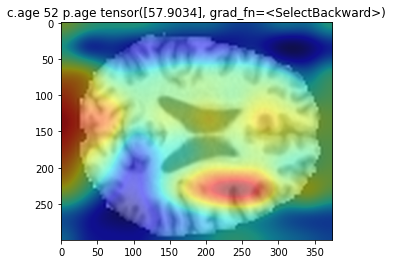

0.49628714 1.0034884
predicted age (model) tensor([54.2554], grad_fn=<SelectBackward>) chron. age 52.0
predicted age (grad cam) tensor([54.2554], grad_fn=<SelectBackward>)
(10, 12) (300, 375)


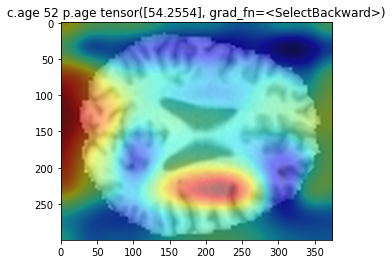

0.50750184 1.0130666
predicted age (model) tensor([53.7519], grad_fn=<SelectBackward>) chron. age 52.0
predicted age (grad cam) tensor([53.7519], grad_fn=<SelectBackward>)
(10, 12) (300, 375)


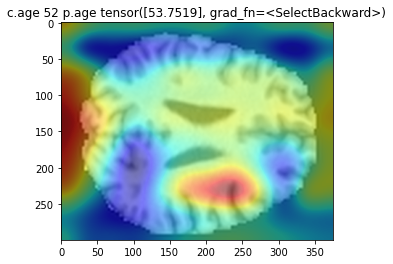

0.5120816 1.0082036
predicted age (model) tensor([55.7420], grad_fn=<SelectBackward>) chron. age 52.0
predicted age (grad cam) tensor([55.7420], grad_fn=<SelectBackward>)
(10, 12) (300, 375)


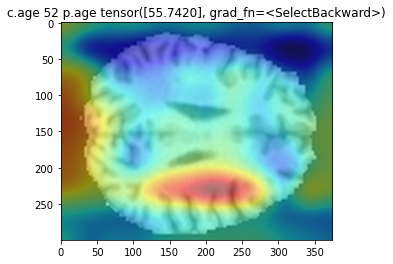

0.4584727 1.0048126
predicted age (model) tensor([53.5315], grad_fn=<SelectBackward>) chron. age 52.0
predicted age (grad cam) tensor([53.5315], grad_fn=<SelectBackward>)
(10, 12) (300, 375)


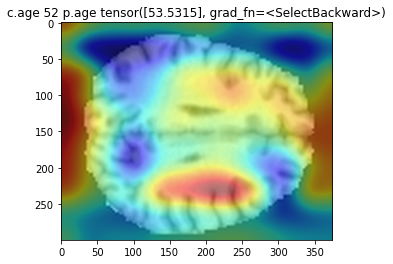

0.53520715 1.0094309
predicted age (model) tensor([47.3825], grad_fn=<SelectBackward>) chron. age 52.0
predicted age (grad cam) tensor([47.3825], grad_fn=<SelectBackward>)
(10, 12) (300, 375)


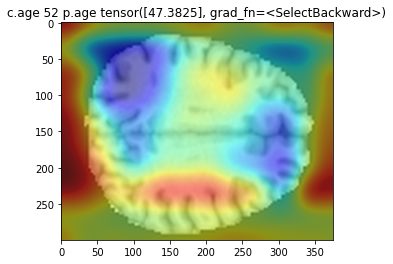

0.3698705 1.0018789


In [22]:
hmaps = []
imgs = []

for idx in range(20,30):
    sample = ds_val[idx]

    # prediction
    input = torch.tensor(sample['data'][np.newaxis, ...]).float()
    y = model(input)[:, 0]
    print(f'predicted age (model) {y} chron. age {sample["label"][0]:.1f}')

    # forward prediction 
    pred = cam(input)
    p_age = pred[:, 0]
    c_age = sample['label'][0]
    print(f'predicted age (grad cam) {p_age}')

    # compute gradients
    pred[:,0].backward()
    gradients = cam.get_activations_gradient()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = cam.get_activations(input).detach()
    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # resample heatmap to original size
    hmap = heatmap.squeeze().numpy()
    img = sample['data'][0]
    zoom = np.array(img.shape)/np.array(hmap.shape)
    heatmap_zoomed = scipy.ndimage.zoom(hmap, zoom)

    print(heatmap.numpy().shape, heatmap_zoomed.shape)

    plt.imshow(img, cmap='gray')
    heatmap_filtered = np.copy(heatmap_zoomed)
    #hmap_filtered[hmap_filtered < 0.0] = 0
    plt.title(f'c.age {c_age} p.age {p_age}')
    plt.imshow(heatmap_filtered, alpha=0.5, cmap='jet')
    plt.show()
    print(heatmap_filtered.min(), heatmap_filtered.max())
    #plt.savefig(out_dir/f'heatmap{str(idx).zfill(4)}.png')

    # store results
    #imgs.append(img)
    #hmaps.append(heatmap_filtered)
    


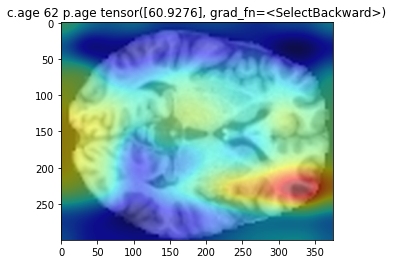

In [16]:
plt.imshow(img, cmap='gray')
heatmap_filtered = np.copy(heatmap_zoomed)
#hmap_filtered[hmap_filtered < 0.0] = 0
plt.title(f'c.age {c_age} p.age {p_age}')
plt.imshow(heatmap_filtered, alpha=0.5, cmap='jet')
plt.savefig(out_dir/'test.png')

torch.Size([8, 10])


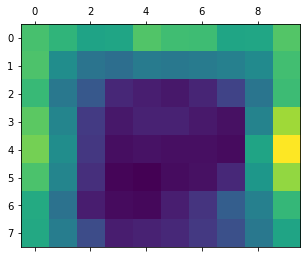

In [31]:
# draw the heatmap
plt.matshow(heatmap.squeeze())
print(heatmap.squeeze().shape)

30


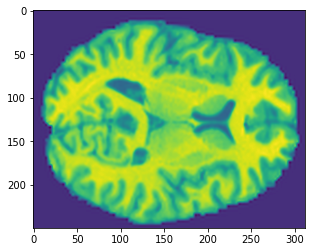

In [32]:
plt.imshow(sample['data'][0].astype(np.float32))
print(sample['label'][0])

Text(0.5, 1.0, 'overlay mean heatmap (min-max-normalized) \n background mean img')

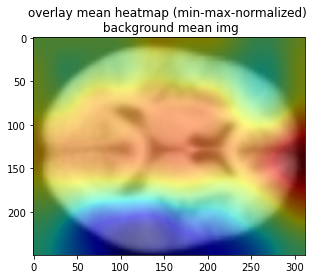

In [57]:
hmap_mean = np.mean(np.stack([(m-m.min())/(m.max()-m.min()) for m in hmaps]), axis=0)
img_mean = np.mean(np.stack([m for m in imgs]), axis=0)
plt.imshow(img_mean, cmap='gray')
plt.imshow(hmap_mean, cmap='jet', alpha=0.5)
plt.title('overlay mean heatmap (min-max-normalized) \n background mean img')

(array([ 256.,  363.,  466.,  532., 1174., 2196., 1717., 1492., 1617.,
         879.]),
 array([20. , 25.2, 30.4, 35.6, 40.8, 46. , 51.2, 56.4, 61.6, 66.8, 72. ]),
 <a list of 10 Patch objects>)

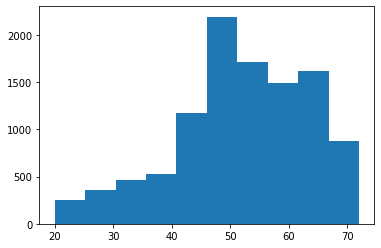

In [70]:
plt.hist(info_df['age'])